In [20]:
"""Volume 2: Non-negative Matrix Factorization."""

import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import os
from imageio import imread
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import NMF
from sklearn.datasets import load_sample_images
from sklearn.metrics import mean_squared_error as mse

In [21]:
#Problems 1-2
class NMFRecommender:

    def __init__(self,random_state=15,rank=3,maxiter=200,tol=1e-3):
        """The parameter values for the algorithm"""

        self.random_state = random_state                #initialize our attributes
        self.tol = tol
        self.rank = rank
        self.maxiter = maxiter
        
        
    
    def initialize_matrices(self,m,n):
        """randomly initialize the W and H matrices,"""

        np.random.seed(self.random_state)           #initialize our matrices using seed so we can call them
        self.W = np.random.rand(m, self.rank)
        self.H = np.random.rand(self.rank, n)
        
        
        return self.W, self.H

      
    def fit(self,V):
        """Fits W and H weight matrices using CVXPY"""
        m,n = V.shape
        W, H = self.initialize_matrices(m,n)          #call our previous method

        for i in range(self.maxiter):                  #continue trying until we reach maxiter
            varW = cp.Variable((m, self.rank), nonneg=True)       #define W as a variable for which we will solve
            obj = cp.Minimize(cp.norm(V-(varW@H), "fro"))
            constraints = None
            prob = cp.Problem(obj, constraints)               #set up the problem and solve it
            prob.solve()
            W = varW.value
            
            varH = cp.Variable((self.rank, n), nonneg=True)            #do the same thing for H
            objective = cp.Minimize(cp.norm(V-(W@varH), "fro"))
            problem = cp.Problem(objective, constraints)
            problem.solve()
            H = varH.value
            
            if np.linalg.norm(V - (W@H), 'fro') < self.tol:       #if we our approximation is close enough terminate
                break
                
        self.H = H
        self.W = W
            
            

    def reconstruct(self):
        """Reconstruct V matrix for comparison against the original V"""

        return (self.W@self.H)               #reconstruct V by using the W and H that we found


In [22]:
def prob3():
    """Run NMF recommender on the grocery store example"""
    V = np.array(
        [
            [0, 1, 0, 1, 2, 2],
            [2, 3, 1, 1 ,2, 2],
            [1, 1, 1, 0, 1, 1],
            [0, 2, 3, 4, 1, 1],
            [0, 0, 0, 0, 1, 0]
        ]
    )

    grocers = NMFRecommender(rank=2)          #define our rank 2 NMF recommender
    grocers.fit(V)                            #find our optimal W and H
    comp1 = grocers.H[0]                      #separate the two components
    comp2 = grocers.H[1]
    h_weits = 0
    
    for p in range(6):
        if comp1[p] < comp2[p]:               #find the number of people with higher weights in comp 2
            h_weits += 1
            
    return np.round(grocers.W,2), np.round(grocers.H,2), h_weits

In [23]:
prob3()

(array([[0.43, 1.56],
        [0.73, 2.67],
        [0.26, 1.23],
        [2.77, 0.  ],
        [0.  , 0.37]]),
 array([[0.  , 0.73, 1.08, 1.45, 0.35, 0.37],
        [0.59, 0.77, 0.07, 0.  , 0.8 , 0.77]]),
 4)

In [24]:

#get data
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory.
    Flatten and convert each image to grayscale.

    Parameters:
        path (str): The directory containing the dataset of images.

    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)

def show(image, m=200, n=180, plt_show=False):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.

    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
        plt_show (bool): if True, call plt.show() at the end
    """
    #scale image
    image = image / 255
    #reshape image
    image = np.reshape(image,(m,n))
    #show image
    plt.imshow(image,cmap = "gray")
    
    if plt_show:
        plt.show()


In [31]:
def prob4():
    """
        Gridsearch over rank, alpha and l1_ratio values to reconstruct 
        image using NMF. Plot all reconstructed images.
    """
    
    dataset = get_faces()             #get the faces
    alphas = [0, .2, .5]              #make lists of the different parameters which we will try
    l1s = [0, 1e-5, 10]
    
    for alpha in alphas:
        for l1 in l1s:
            model = NMF(n_components = 75, alpha=alpha, l1_ratio = l1)
            W = model.fit_transform(dataset)         #plot the reconstructions of the face with each parameter
            H = model.components_
            V = W@H[:,2]
            
            plt.title('Alpha = ' + str(alpha) + " Ratio = " + str(l1))
            show(V, plt_show=True)


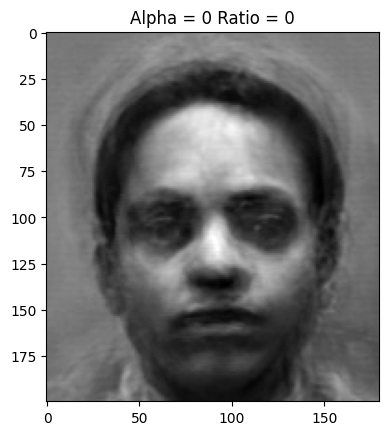

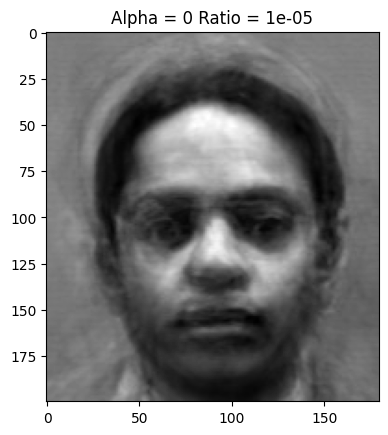

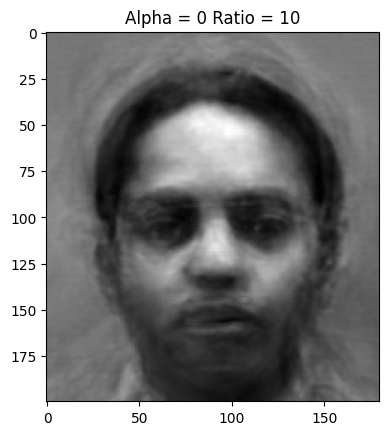

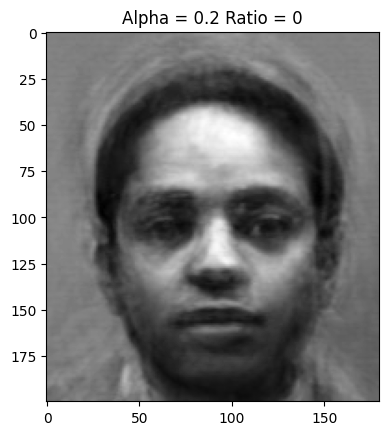

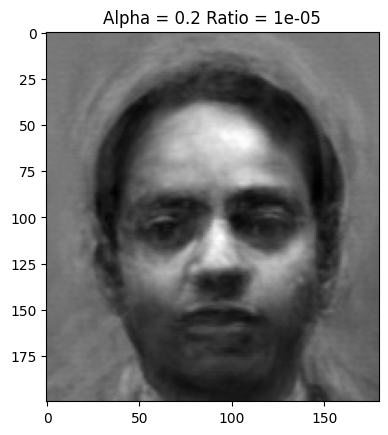

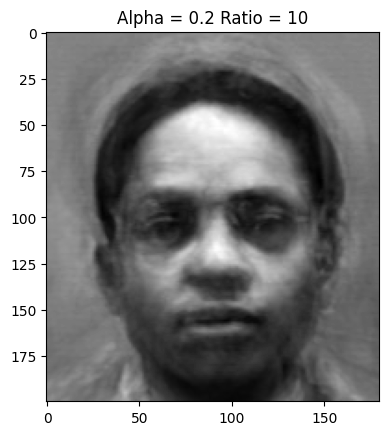

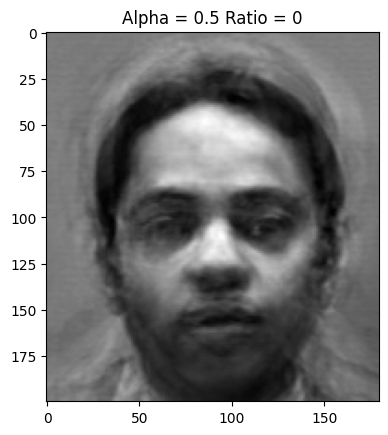

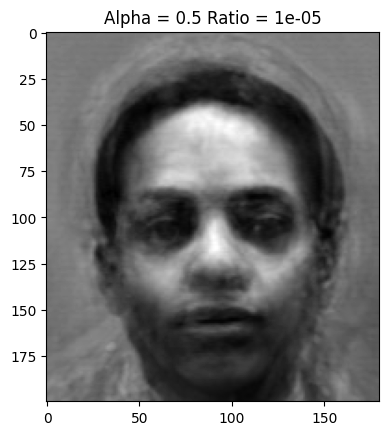

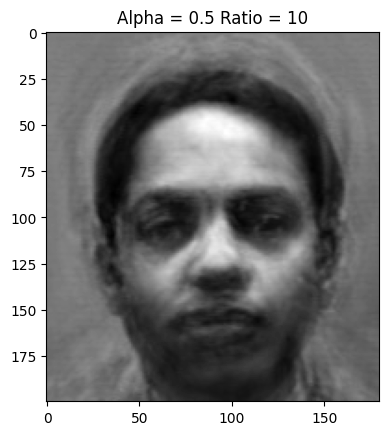

In [32]:
prob4()

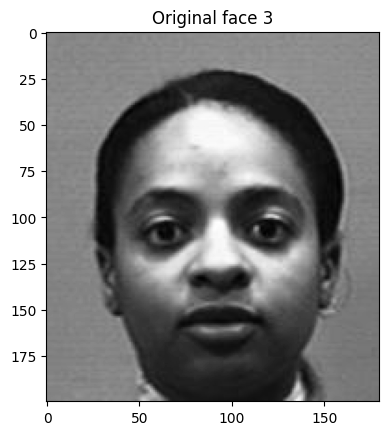

In [50]:
dataset = get_faces()
plt.title("Original face 3")             #plot the original face for comparison
show(dataset[:,2], plt_show=True)

In [41]:
def prob5():
    '''
        find the 10 basis faces with the largest coefficients 
        corresponding to the the second and twelfth face in the dataset. 
        Plot these basis faces along with the original image using 
        subplots
    '''
    model = NMF(n_components=75, alpha=.2, l1_ratio=1e-5)      #set up the NMF with the best parameters
    dataset = get_faces()
    W = model.fit_transform(dataset)
    H = model.components_
    
    for face in [1,11]:
        plt.title("Original face " + str(face+1))           #plot the original faces
        show(dataset[:,face], plt_show=True)
        basis = np.argsort(H[:, face])[-10:]                #find the ten best basis matches
        
        for pic in basis:                                   #plot the basis matches
            V = W[:, pic]
            plt.title("Face number " + str(face+1) + ", Basis Index: " + str(pic))
            show(V, plt_show=True)

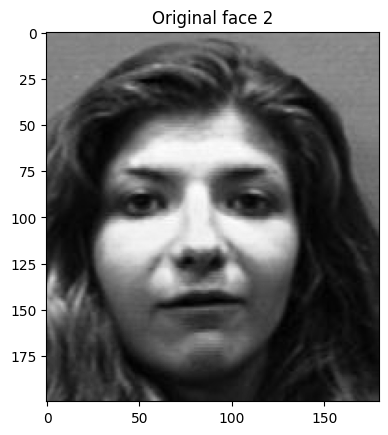

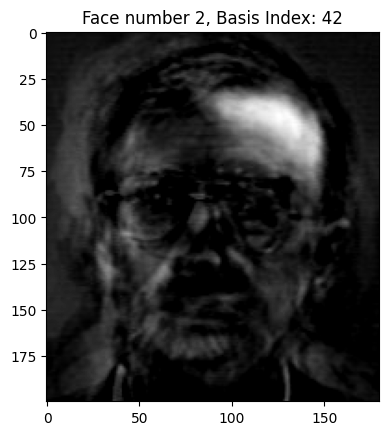

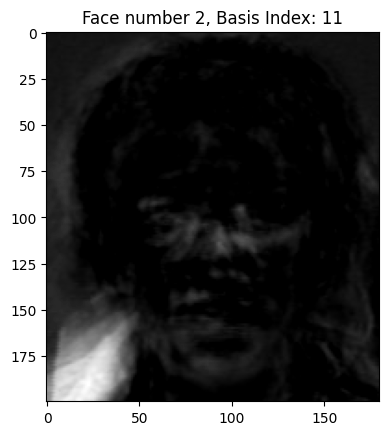

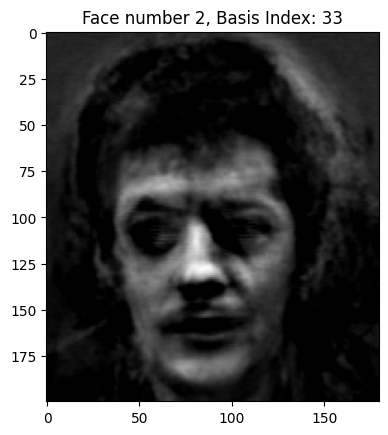

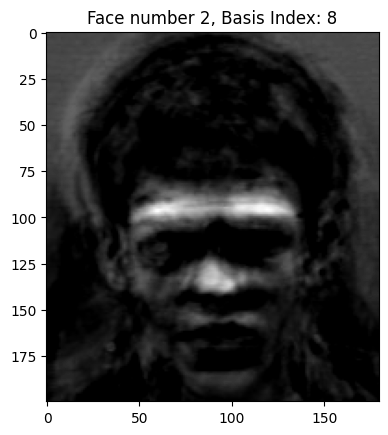

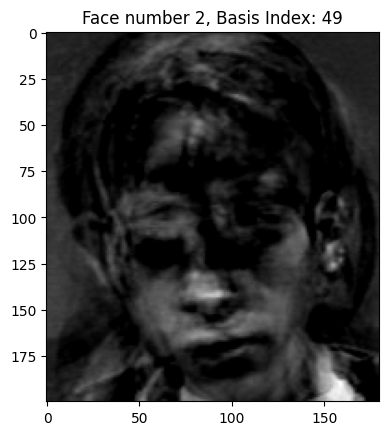

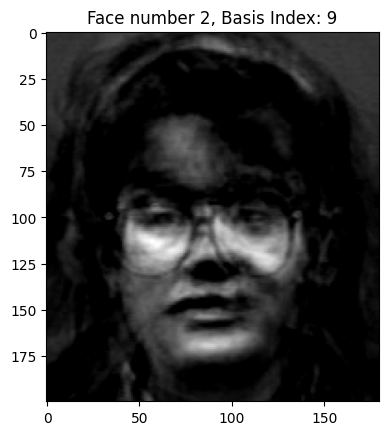

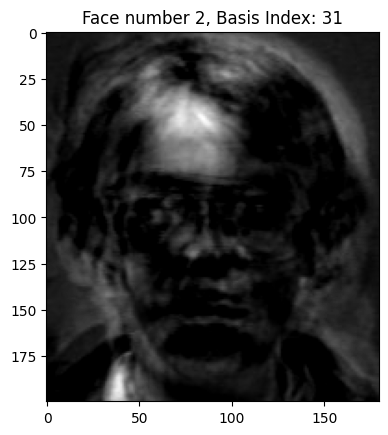

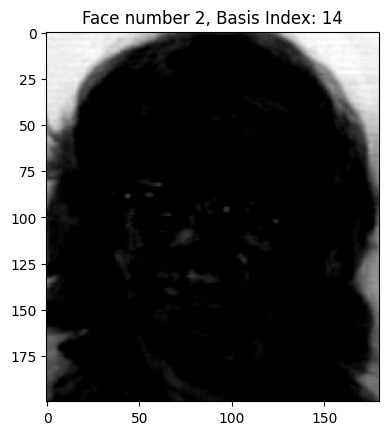

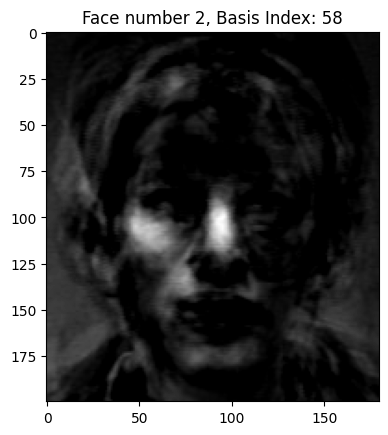

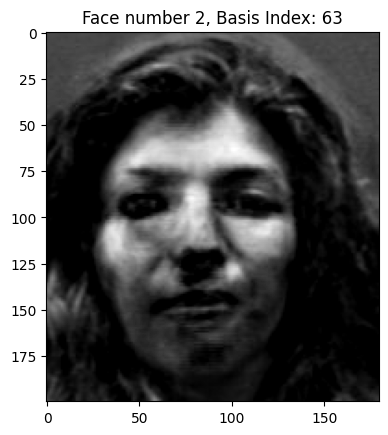

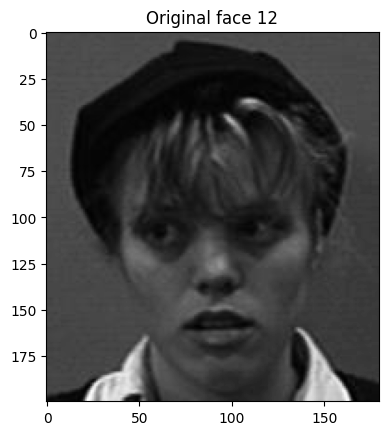

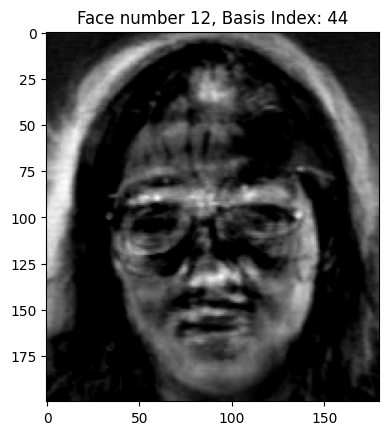

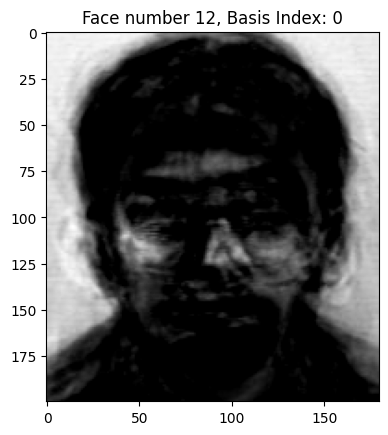

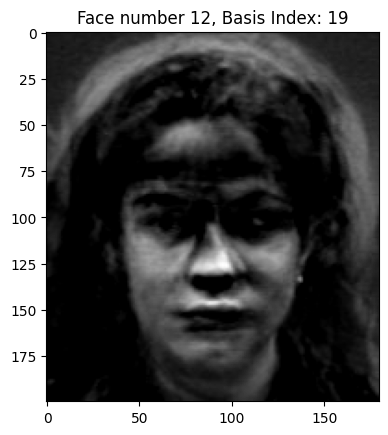

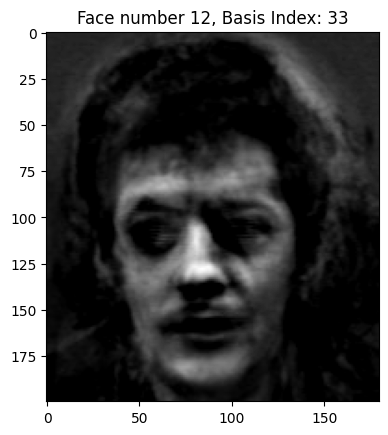

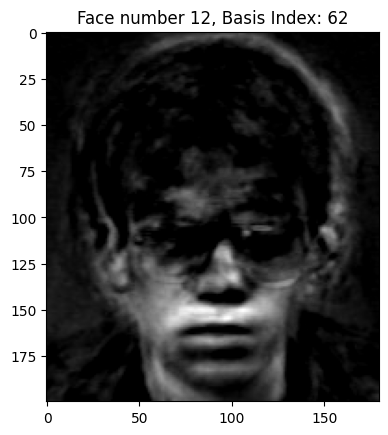

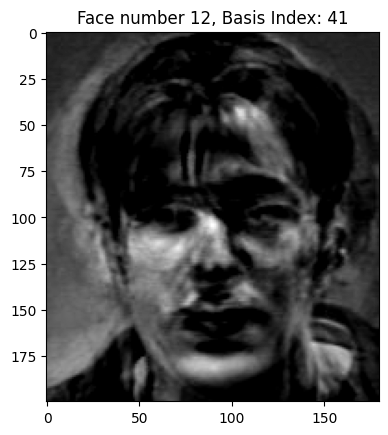

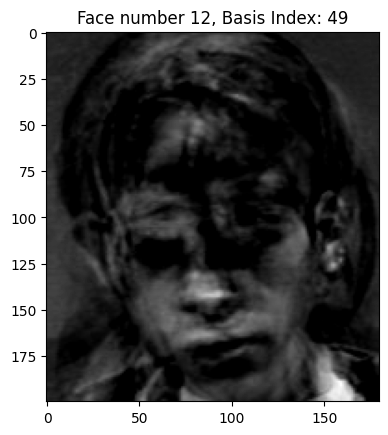

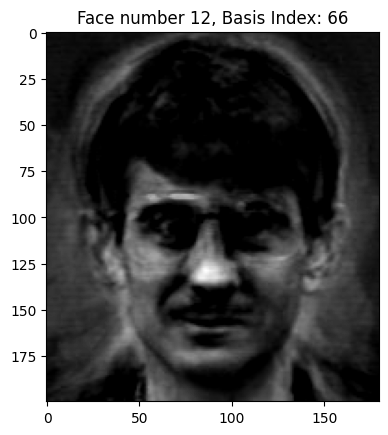

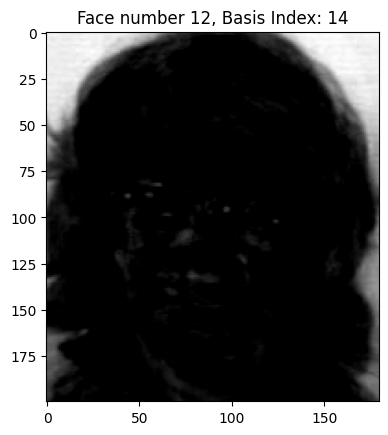

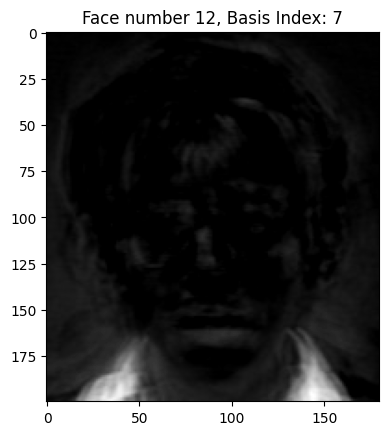

In [54]:
prob5()

My face 2 has rather large cheeks so it seems that the basis faces that were generated had somewhat wider faces. My face twelve had deepset eyes and kind of an open mouth which was reflected in the choice of basis faces.